# Splitting image on harddisk script

In [1]:
from PIL import Image
import numpy as np
from patchify import patchify
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import tensorflow as tf
import tensorflow_io as tfio


In [115]:
source_path = '../raw_data/aerial_images_inria1358/AerialImageDataset'
save_path = '../raw_data/aerial_images_inria1358/patches'

In [117]:
def make_patches(source_path, save_path, set):
    subfolders = ['images']
    if set == 'train':
        subfolders.append('gt')
    
    for subfolder in subfolders:
        load_path = f'{source_path}/{set}/{subfolder}'
        save_path_n = f'{save_path}/{set}/{subfolder}'
        # Check whether the specified path exists or not
        isExist = os.path.exists(save_path_n)
        if not isExist:
            os.makedirs(save_path_n)
        print("-"*10)
        print(f" Iterating through folder: {subfolder}")
        print("-"*10)
        
        dimensions = (200,200) if subfolder == "gt" else (200,200,3)
        
        for filename in tqdm(os.listdir(load_path)):
            im = Image.open(f'{load_path}/{filename}')
            imarray = np.array(im)
            patches = patchify(imarray, dimensions, step=200)
            for i, row in enumerate(patches):
                for j, col in enumerate(row):
                    if subfolder == "gt":
                        im = Image.fromarray(col)
                    else:
                        im = Image.fromarray(col[0])
                    im.save(f'{save_path_n}/{filename}__{i}__{j}.png')

## Patch Debugging

In [114]:
load_path = "../raw_data/aerial_images_inria1358/AerialImageDataset/train/images/austin1.tif"
save_path_n = "../raw_data/aerial_images_inria1358/debug"
# Check whether the specified path exists or not
subfolder = "images"
isExist = os.path.exists(save_path_n)
if not isExist:
    os.makedirs(save_path_n)
    

dimensions = (200,200) if subfolder == "gt" else (200,200,3)

im = Image.open(load_path)
imarray = np.array(im)
patches = patchify(imarray, dimensions, step=200)
for i, row in enumerate(patches):
    for j, col in enumerate(row):
        if subfolder == "gt":
            im = Image.fromarray(col)
        else:
            im = Image.fromarray(col[0])
        im.save(f'{save_path_n}/austin1__{i}__{j}.png')

In [103]:
im = Image.open(load_path)
imarray = np.array(im)

In [104]:
patches = patchify(imarray, dimensions, step=200)


In [105]:
im = Image.fromarray(patches[0][0])

In [106]:
im = im.convert('1') # convert image to black and white

In [109]:
im.save(f'{save_path_n}/aaaaustin1____.png')

In [111]:
mask = tf.io.read_file(f'{save_path_n}/aaaaustin1____.png')
mask = tf.io.decode_png(mask, channels=1)
mask

<tf.Tensor: shape=(200, 200, 1), dtype=uint8, numpy=
array([[[  0],
        [  0],
        [  0],
        ...,
        [255],
        [255],
        [255]],

       [[  0],
        [  0],
        [  0],
        ...,
        [255],
        [255],
        [255]],

       [[  0],
        [  0],
        [  0],
        ...,
        [  0],
        [255],
        [255]],

       ...,

       [[  0],
        [  0],
        [  0],
        ...,
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        ...,
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        ...,
        [  0],
        [  0],
        [  0]]], dtype=uint8)>

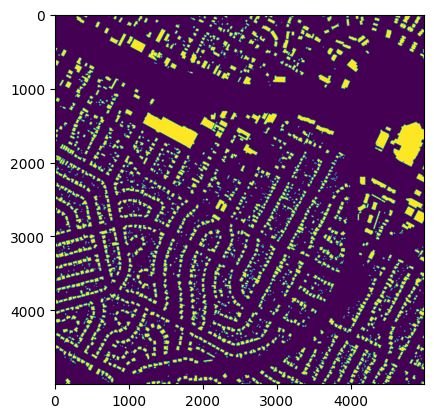

In [91]:
plt.imshow(imarray)

## Making Patches

In [4]:
# Takes a while
#make_patches(source_path, save_path, set='test')

In [119]:
# Takes a while
make_patches(source_path, save_path, set='train')

----------
 Iterating through folder: images
----------


100%|██████████| 180/180 [21:23<00:00,  7.13s/it]


----------
 Iterating through folder: gt
----------


100%|██████████| 180/180 [01:22<00:00,  2.19it/s]


# Helper Functions for Showing Imakes/Masks

In [6]:
def show_full_image_split(image_name, mask=False):
    path = f"{save_path}/train/gt" if mask else f"{save_path}/train/images" 
    train_images = os.listdir(f"{save_path}/train/images")
    
    filtered_train_images = [fname for fname in train_images if fname.__contains__(image_name)]
    plt.figure(figsize=(15, 15))
    plt.title(f"Image: {image_name}")
    count = 0
    for r in tqdm(range(25)):
        for c in range(25):
            ax = plt.subplot(25, 25, count+1)
            ax.set_xticks([])
            ax.set_yticks([])
            if mask:
                plt.imshow(Image.open(f"{path}/{image_name}__{r}__{c}.tiff"), cmap="gray")
            else:
                plt.imshow(Image.open(f"{path}/{image_name}__{r}__{c}.tiff"))
            count += 1

In [7]:
def show_mask_comparison(file_name):
    mask_path = f"{save_path}/train/gt/{file_name}"
    img_path = f"{save_path}/train/images/{file_name}"
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(Image.open(img_path))
    ax[0].set_title("Original Image")
    
    ax[1].imshow(Image.open(mask_path), cmap="gray")
    ax[1].set_title("Original Mask")
    print(mask_path)
    print(img_path)

In [8]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if(i==2):
        plt.imshow(display_list[i], cmap='gray')
    else:
        plt.imshow(display_list[i])
  plt.show()

In [221]:
def display_full(file_name, predict_mask, threshold=0.5):
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    mask_path = f"{source_path}/train/gt/{file_name}"
    img_path = f"{source_path}/train/images/{file_name}"

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
    ax[0].imshow(Image.open(img_path))
    ax[0].set_title("Original Image")
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    
    ax[1].imshow(Image.open(mask_path), cmap="gray")
    ax[1].set_title("Original Mask")
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    ax[2].imshow(predict_mask>threshold, cmap="gray")
    ax[2].set_title(f"Predicted Mask (Threshold: {threshold})")
    ax[2].set_xticks([])
    ax[2].set_yticks([])

In [9]:
def combine_patches(images):
    """ 
        Combines image arrays (for instance from predict) to full image
        
        Args:
            images: 2D Array with rows cols containing tensors/images arrays
    """
    rows = [np.hstack(images[r]) for r in tqdm(range(25))]
    
    return np.vstack(rows)

../raw_data/aerial_images_inria1358/patches/train/gt/austin1.tif__0__10.tiff
../raw_data/aerial_images_inria1358/patches/train/images/austin1.tif__0__10.tiff


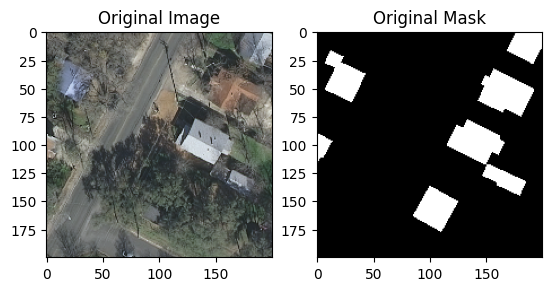

In [10]:
show_mask_comparison("austin1.tif__0__10.tiff")

In [11]:
#show_full_image_split("austin1.tif", mask=True)

# Creating Dataset

## Helper Function

In [156]:
def load_and_preprocess_data(image_path, mask_path=None):
    # Load and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=3)
    image = image/255
    #image = tf.pad(image, [[12,12], [12,12], [0,0]], mode='REFLECT') #To be removed and model adjusted
            
    
    # Load and preprocess the mask image
    if mask_path is not None: 
        mask = tf.io.read_file(mask_path)
        mask = tf.io.decode_png(mask, channels=1)
        mask = mask/255
        #mask = tf.pad(mask, [[12,12], [12,12], [0,0]], mode='REFLECT') #To be removed and model adjusted

        return image, mask
    else:
        return image

In [174]:
img_path = "../raw_data/aerial_images_inria1358/patches/train/images/austin1.tif__0__10.png"
mask_path = "../raw_data/aerial_images_inria1358/patches/train/gt/austin1.tif__0__10.png"

image, mask = load_and_preprocess_data(img_path, mask_path)

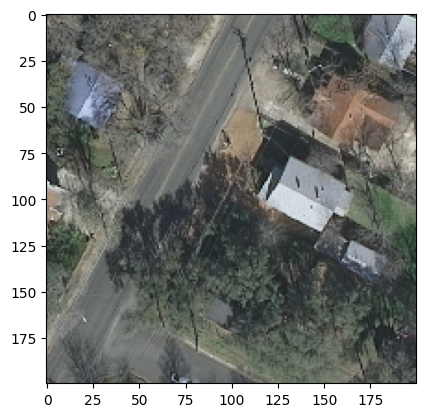

In [175]:
plt.imshow(image)

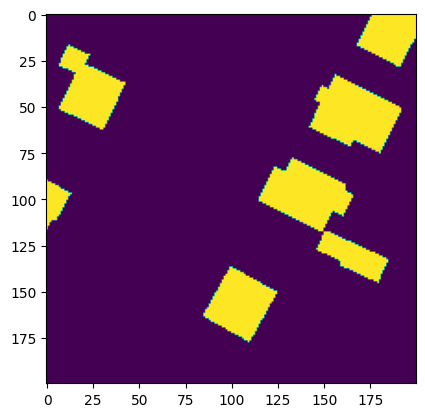

In [177]:
plt.imshow(mask)

## Defining Variables (Mask/IMages Paths, Test Set Size)

In [161]:
image_dir = f'{save_path}/train/images'
mask_dir = f'{save_path}/train/gt'

image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir)]
mask_paths = [os.path.join(mask_dir, filename) for filename in os.listdir(mask_dir)]

In [162]:
elements = len(image_paths)

test_ratio = 0.1

test_size = int(test_ratio * elements)

In [163]:
test_size

11250

## Building Dataset

In [164]:
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
dataset = dataset.map(load_and_preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

In [225]:
train_dataset = dataset.skip(test_size*6)
test_dataset = dataset.take(test_size)

In [226]:
#.cache("../raw_data/cache_train")
train_batches = (train_dataset
                 .shuffle(1000)
                 .batch(64)).prefetch(buffer_size=tf.data.AUTOTUNE) # should probably shuffle before splitting

#.cache("../raw_data/cache_test")
test_batches = (test_dataset
                 .shuffle(1000)
                 .batch(64)).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building Model

## Helper Functions

In [227]:
def predict_full_image(model, image_name):
    """ 
        Combines image arrays (for instance from predict) to full image
        
        Args:
            images: 2D Array with rows cols containing tensors/images arrays
    """
    path = f"{save_path}/train/images" 
    
    predict_data = [] # 2D Array (rows, cols) holding the predictions
    for r in tqdm(range(25)):
        col = []
        for c in range(25):
            # Load Image
            img_path = f"{path}/{image_name}__{r}__{c}.png"
            
            # Preparing for prediction
            image = load_and_preprocess_data(img_path)
            image = tf.expand_dims(image, axis=0)
            
            # Predict
            predict_mask = model.predict(image, verbose=0)
            
            # Remove batch
            predict_mask = tf.squeeze(predict_mask)
            
            col.append(predict_mask)
        predict_data.append(col)
    
    return predict_data

## UNET Model

In [228]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

input_shape = (200, 200, 3)

inputs = Input(input_shape)

c1 = Conv2D(64, (3,3), activation="relu", padding="same")(inputs)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(128, (3,3), activation="relu", padding="same")(p1)
p2 = MaxPooling2D((2,2))(c2)

c3 = Conv2D(256, (3,3), activation="relu", padding="same")(p2)
p3 = MaxPooling2D((2,2))(c3)

b = Conv2D(512, (3,3), activation="relu", padding="same")(p3)

u1 = UpSampling2D((2,2))(b)
concat1 = Concatenate()([u1, c3])
c4= Conv2D(256, (3,3), activation="relu", padding="same")(concat1)

u2 = UpSampling2D((2,2))(c4)
concat2 = Concatenate()([u2, c2])
c5= Conv2D(128, (3,3), activation="relu", padding="same")(concat2)

u3 = UpSampling2D((2,2))(c5)
concat3 = Concatenate()([u3, c1])
c6= Conv2D(64, (3,3), activation="relu", padding="same")(concat3)

outputs = Conv2D(1, (1,1), activation="sigmoid")(c6)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])


## SEGNET Model

In [229]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model

def encoder_block(x, filters):
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    return x

def decoder_block(x, filters):
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def build_segnet(input_shape):
    inputs = Input(shape=input_shape)
    
    # Encoder
    enc1 = encoder_block(inputs, 64)
    enc2 = encoder_block(enc1, 128)
    enc3 = encoder_block(enc2, 256)
    
    # Decoder
    dec3 = decoder_block(enc3, 256)
    dec2 = decoder_block(dec3, 128)
    dec1 = decoder_block(dec2, 64)
    
    # Pixel-wise classification
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(dec1)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the SegNet model
input_shape = (200, 200, 3)
segnet_model = build_segnet(input_shape)
segnet_model.summary()

# Compile the model
segnet_model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 200, 200, 3)]     0         
                                                                 
 conv2d_99 (Conv2D)          (None, 200, 200, 64)      1792      
                                                                 
 batch_normalization_30 (Ba  (None, 200, 200, 64)      256       
 tchNormalization)                                               
                                                                 
 activation_30 (Activation)  (None, 200, 200, 64)      0         
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 100, 100, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_100 (Conv2D)         (None, 100, 100, 128)     738

In [230]:
history = model.fit(train_batches, validation_data=test_batches, epochs=2)

Epoch 1/2


2023-09-21 12:01:45.956628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-21 12:01:58.056463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1 of 1000
2023-09-21 12:01:58.244523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


  5/704 [..............................] - ETA: 39:52 - loss: 0.8306 - accuracy: 0.8387

In [135]:
# Save model
# sgnet_model_halfset.h5 = model with 5 epochs trained on 50% of the dataset
# segnet_model_20percent.h5 = m'odel with 2 epochs trained on 20% of the dataset
segnet_model.save('segnet_model_20percent.h5')

/Users/paulrenger/.pyenv/versions/3.10.6/envs/inria1358/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Predicting using SEGNET

In [22]:
img_path = "../raw_data/aerial_images_inria1358/patches/train/images/austin1.tif__0__10.tiff"
mask_path = "../raw_data/aerial_images_inria1358/patches/train/gt/austin1.tif__0__10.tiff"

image, mask = load_and_preprocess_data(img_path, mask_path)

In [186]:
img_to_predict = "austin1.tif"
predict_data = predict_full_image(model, img_to_predict)
combined_mask = combine_patches(predict_data)


  0%|          | 0/25 [00:00<?, ?it/s]

2023-09-21 11:42:39.971010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
100%|██████████| 25/25 [00:00<00:00, 50.44it/s]


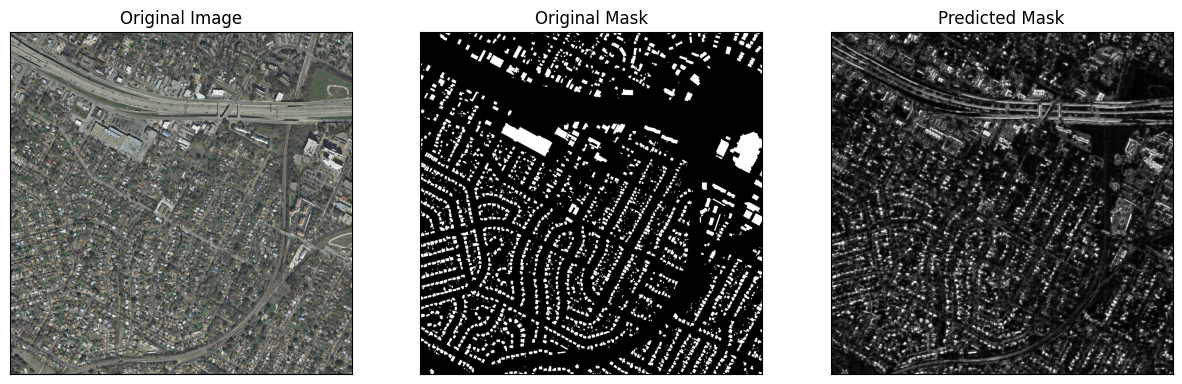

In [189]:
display_full(img_to_predict, combined_mask)

In [214]:
img_to_predict = "austin1.tif"
predict_data = predict_full_image(model, img_to_predict)
combined_mask = combine_patches(predict_data)

100%|██████████| 25/25 [00:00<00:00, 107.83it/s]


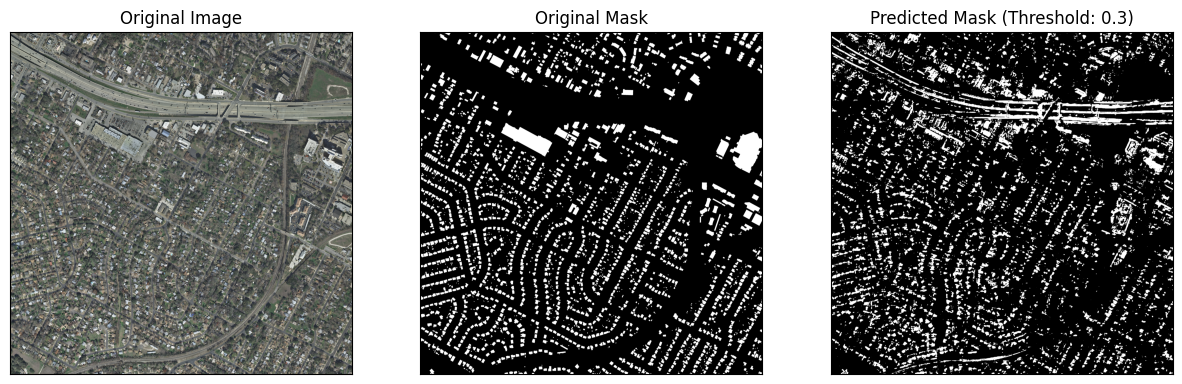

In [224]:
display_full(img_to_predict, combined_mask, threshold=0.3)

# Splitting image in tensorflow RAM

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import os

2023-09-19 15:59:40.077349: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
class TIFImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_dir, mask_dir, batch_size, img_size):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.image_filenames = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_filenames) // self.batch_size

    def __getitem__(self, index):
        batch_files = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        X = []  # 3 channels for RGB
        # y = np.zeros((self.batch_size, *self.img_size, 1))  # 1 channel for grayscale
        
        first_iteration = True
        for file in batch_files:
            tensor = tf.io.read_file(f'{self.image_dir}/{file}')
            tensor = tfio.experimental.image.decode_tiff(tensor)
            tensor = tf.pad(tensor, [[60,60], [60,60], [0,0]], mode='CONSTANT', constant_values=-1)
            image_tensor = tf.expand_dims(tensor, axis=0)
            if first_iteration:
                X = image_tensor
                first_iteration = False
            else:
                X = tf.concat([X, image_tensor], axis=0)
            
            # X.append(tensor)

            # img_path = os.path.join(self.image_dir, file)
            # mask_path = os.path.join(self.mask_dir, file)  # Assuming masks have the same filenames
            
            # # Load images in RGB and masks in grayscale
            # img = Image.open(img_path).convert('RGB').resize(self.img_size)
            # mask = Image.open(mask_path).convert('L').resize(self.img_size)
            
            # X[i] = np.array(img) / 255.0  # Normalize to [0, 1]
            # y[i] = np.expand_dims(np.array(mask), axis=-1) / 255.0
        X = tf.image.extract_patches(
        X,
        sizes = [1, 256, 256, 1],
        strides = [1, 256, 256, 1],
        rates = [1, 1, 1, 1],
        padding = 'VALID'
        )
        X = tf.reshape(
            X,
            shape=(2000, 256, 256, 4)
        )
        X = X/255

        return X


    


In [21]:
BATCH_SIZE = 5
IMG_SIZE = 0
images_path = '/home/konrad.horber/code/bergerbastian/inria1358/raw_data/aerial_images_inria1358/AerialImageDataset/train/images'
ref_path = 0
train_gen = TIFImageGenerator(images_path, ref_path, BATCH_SIZE, IMG_SIZE)

In [22]:
variable = train_gen.__getitem__(0)

TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.


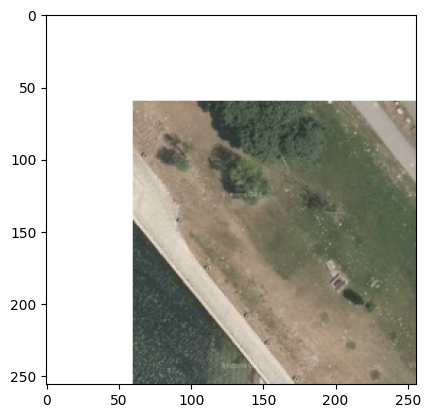

In [25]:
plt.imshow(variable[0])

In [7]:
variable = tf.convert_to_tensor(
    variable
)

In [8]:
variable = tf.image.extract_patches(
    variable,
    sizes = [1, 256, 256, 1],
    strides = [1, 256, 256, 1],
    rates = [1, 1, 1, 1],
    padding = 'VALID'
)
variable = tf.reshape(
    variable,
    shape=(2000, 256, 256, 4)
)
variable = variable/255

In [5]:
dirpath='/home/konrad.horber/code/bergerbastian/inria1358/raw_data/aerial_images_inria1358/AerialImageDataset/train/images'
tensor_batch = []
count = 0

for i in os.listdir(dirpath)
    for filename in os.listdir(dirpath):
        # if count >= 10:
        #     break
        tiff = tf.io.read_file(f'{dirpath}/{filename}')
        tensor = tfio.experimental.image.decode_tiff(tiff)
        chicago1_tensor_pad = tf.pad(tensor, [[60,60], [60,60], [0,0]], mode='CONSTANT', constant_values=-1)
        tensor_batch.append(tensor)
        count += 1


TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 42113 (0xa481) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 4

In [6]:
tensor_batch = tf.convert_to_tensor(tensor_batch)

2023-09-19 15:14:53.003811: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18000000000 exceeds 10% of free system memory.


: 

In [4]:
tensor_batch.shape

TensorShape([10, 5000, 5000, 4])

In [ ]:
tf.conver_to_tensor_batch

In [121]:
chicago1 = tf.io.read_file('/home/konrad.horber/code/bergerbastian/inria1358/raw_data/aerial_images_inria1358/AerialImageDataset/train/images/chicago1.tif')

In [127]:
chicago1_tensor = tfio.experimental.image.decode_tiff(
    chicago1
)

In [140]:
chicago1_tensor.__sizeof__()

152

In [128]:
chicago1_tensor.shape

TensorShape([5000, 5000, 4])

In [129]:
chicago1_tensor_pad = tf.pad(chicago1_tensor, [[60,60], [60,60], [0,0]], mode='CONSTANT', constant_values=-1)

In [130]:
chicago1_tensor_pad.shape

TensorShape([5120, 5120, 4])

In [131]:
chicago1_tensor_pad_batch = tf.expand_dims(chicago1_tensor_pad, axis=0)

In [132]:
chicago1_tensor_pad_batch.shape

TensorShape([1, 5120, 5120, 4])

In [133]:
chicago1_tensor_pad_batch_extract = tf.image.extract_patches(
    chicago1_tensor_pad_batch,
    sizes = [1, 256, 256, 1],
    strides = [1, 256, 256, 1],
    rates = [1, 1, 1, 1],
    padding = 'VALID'
)

In [134]:
chicago1_tensor_pad_batch_extract.shape

TensorShape([1, 20, 20, 262144])

In [135]:
chicago1_tensor_pad_batch_extract_reshape = tf.reshape(
    chicago1_tensor_pad_batch_extract,
    shape=(400, 256, 256, 4)
)

In [136]:
chicago1_tensor_pad_batch_extract_reshape_scaled = chicago1_tensor_pad_batch_extract_reshape/255

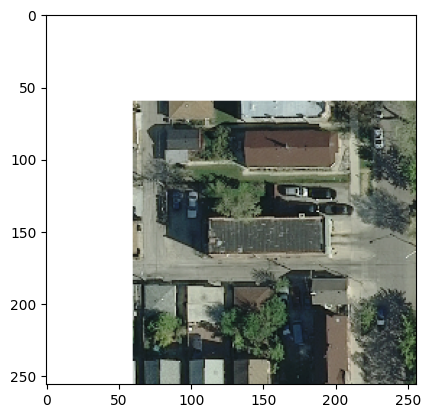

In [139]:
plt.imshow(chicago1_tensor_pad_batch_extract_reshape_scaled[0])

[#images * 20*20, 256, 256, 4]

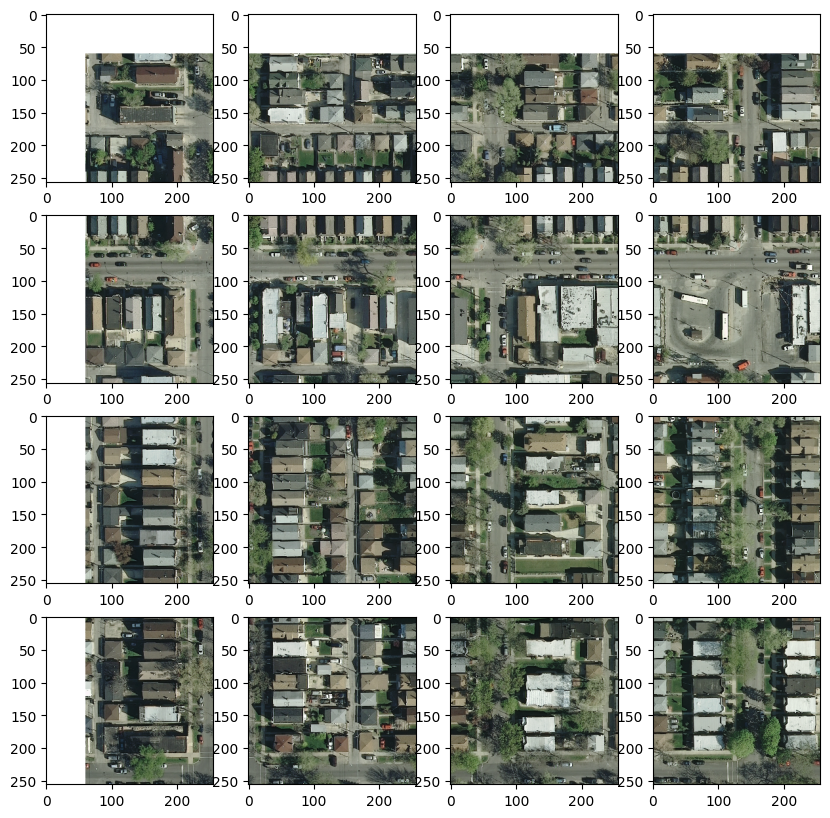

In [87]:
plt.figure(figsize=(10, 10))
for imgs in chicago1_tensor_pad_batch_extract:
    count = 0
    for r in range(4):
        for c in range(4):
            ax = plt.subplot(4, 4, count+1)
            plt.imshow(tf.reshape(imgs[r,c],shape=(256,256,4)).numpy().astype("uint8"))
            count += 1

In [30]:
chicago1_tensor_pad.shape

TensorShape([5120, 5120, 4])

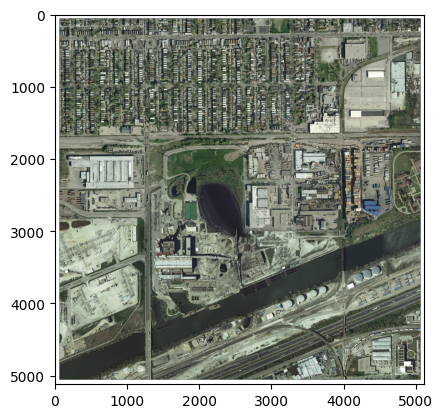

In [31]:
plt.imshow(chicago1_tensor_pad)

In [21]:
chicago1_tensor_pad = tf.keras.layers.ZeroPadding2D(
    padding=(60,60)
)

In [22]:
chicago1_tensor_pad.

AttributeError: 'ZeroPadding2D' object has no attribute 'shape'

In [ ]:
chci

In [8]:
one, two = tf.split(
    chicago1_tensor,
    num_or_size_splits=2,
    axis=0
)

In [10]:
one

TensorShape([2500, 5000, 4])

In [12]:
one_one, one_two = tf.split(
    one,
    num_or_size_splits=2,
    axis=1
)

In [13]:
one_one.shape

TensorShape([2500, 2500, 4])

In [ ]:
image_size=(200,200)